# Logistic regression for a binary classification with a regularization
## 융합공학부 디지털이미징전공 4학년 신준섭 20175437

In [28]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import time

## 1. Training Data
* loading datas from ```data-nonlinear.txt```
* each row $ \{ x^{(i)}, y^{(i)}, l^{(i)} \}$ od the data consists of 2D point $(x, y)$ with its label $l$
* since it is binary classification problem, and with real point $(x, y)$
$$(x, y) \in \mathbb{R},    l \in {0, 1} $$

In [29]:
data    = np.genfromtxt("data-nonlinear.txt", delimiter=',')

pointX  = data[:, 0]
pointY  = data[:, 1]
label   = data[:, 2]

pointX0 = pointX[label == 0]
pointY0 = pointY[label == 0]

pointX1 = pointX[label == 1]
pointY1 = pointY[label == 1]

## 1-1. Matrix representations

$$ x_i = [1, x^{(i)}, y^{(i)}]^T$$
where this can be formed in Matrix representaion
\begin{gather}
    D = 
    \begin{bmatrix}
        x_1^T \\ ... \\ x_N^T
    \end{bmatrix}
    =
    \begin{bmatrix}
        1 & x_{1} & y_{1} \\ & ... & \\ 1 & x_{N} & y_{N}
    \end{bmatrix}
\end{gather}
for the label $l_{i} \in \{0, 1\}$
\begin{gather}
    L =
    \begin{bmatrix}
        l_1 \\ l_2 \\ ... \\ l_N
    \end{bmatrix}
\end{gather}


In [30]:
N = len(label)
Ones = np.ones((N, 1), dtype=float)
Xs = np.matrix(pointX.reshape(N, 1))
Ys = np.matrix(pointY.reshape(N, 1))

D = np.concatenate((Ones, Xs, Ys), axis=1)
L = np.matrix(label).reshape(N, 1)

## 2. Logistic regression with a high dimensional feature function
* the sigmoid function for classification
$$\sigma(z) = \frac{1}{1+\exp\{-z\}}$$
* derivative of the sigmoid
$$\sigma^{'}(z) = \sigma(z)(1-\sigma(z))$$

In [31]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-1.0 * z))

def deriv_sigmoid(z):
    _ones = np.ones(z.shape)
    return np.multiply(sigmoid(z), _ones - sigmoid)

## 2-1. Defining high dimensional matrix

* to use the computation as matrix, we can divide $x$ and $y$ as
$$\hat{x} = [x^0, x^1, ..., x^9], \hspace{5mm} \hat{y} = [y^0, y^1, ..., y^9]$$
* where the 2D representation can be
$$F = \hat{x}^T \cdot \hat{y}$$
\begin{gather}
    F =
    \begin{bmatrix}
        1   &   y   &  y^2    & ... & y^9 \\
        x   &  xy   &  xy^2   &  ...    & xy^9 & \\
        x^2 &  x^2y &  x^2y^2 &  ...    & x^2y^9 & \\
        \vdots &  \vdots  &   \vdots   &  \ddots    & \vdots & \\
        x^9 & x^9y & x^9y^2 & ... & x^9 y^9
    \end{bmatrix},
    \hspace{1cm} \Theta = 
    \begin{bmatrix}
        \theta_{0,0} & \theta_{0,1} & \theta_{0,2} & ... & \theta_{0,9} \\
        \theta_{1,0} & \theta_{1,1} & \theta_{1,2} & ... & \theta_{1,9} \\
        \theta_{2,0} & \theta_{2,1} & \theta_{2,2} & ... & \theta_{2,9} \\
        \vdots &  \vdots  &   \vdots   &  \ddots    & \vdots & \\
        \theta_{9,0} & \theta_{9,1} & \theta_{9,2} & ... & \theta_{9,9} \\
    \end{bmatrix}
\end{gather}

* since the linear combination is formed as
$$g(x, y; \theta) = \sum_{i=0}^{9} \theta_{i, j} x^i y^j$$

* $G$ matrix can be formed as elementwise multiplication of $F$ and $\Theta$
$$G = \sum_{i,j} F \circ \Theta$$

## 2-2. Representing into 3-dimension matrix

* since the value $x$ and $y$ is a vector, we can think of 3D matrix as follow
\begin{gather}
    F_k =
    \begin{bmatrix}
        1   &   y_k   &  y_k^2    & ... & y_k^9 \\
        x_k   &  x_ky_k   &  x_ky_k^2   &  ...    & x_ky_k^9 & \\
        x_k^2 &  x_k^2y_k &  x_k^2y_k^2 &  ...    & x_k^2y_k^9 & \\
        \vdots &  \vdots  &   \vdots   &  \ddots    & \vdots & \\
        x_k^9 & x_k^9y_k & x_k^9y_k^2 & ... & x_k^9 y_k^9
    \end{bmatrix},
    where \hspace{2mm} k \in [1, N]
\end{gather}

* the $\mathbf{F}$ is depth-wise concatenation of all $F_k$

* then the corresponding $G_k$ is
$$ G_k = \sum_{i,j} F_k \circ \Theta$$

* finally, $\mathbf{G}$ is the concatenation of all $G_k$

In [32]:
Xps, Yps = [], []
for p in range(10):
    Xps.append(np.power(Xs, p))
    Yps.append(np.power(Ys, p))
Xps, Yps = tuple(Xps), tuple(Yps)

Xps, Yps = np.concatenate(Xps, axis=1), np.concatenate(Yps, axis=1)

Fks = []
for k in range(N):
    Xp, Yp = Xps[k, :], Yps[k, :]
    Fk = np.matmul(np.transpose(Xp), Yp)
    Fks.append(Fk)

def linComb(Fk, Theta):
    Gk = np.sum(np.multiply(Fk, Theta))
    return Gk

## 3. Objective Function with a regularization term
* objective function for logistic regression is
$$\hat{J}(\theta) = \frac{1}{N}\sum_{k=1}^{N} [-l_k \log(\sigma(g(x_k, y_k; \theta))) - (1-l_k)\log(1-\sigma(g(x_k, y_k; \theta)))]$$

* and the L2 regularization is
$$L(\lambda; \theta) = \frac{\lambda}{2} \sum_{i=0}^{9}\sum_{j=0}^{9}\theta_{i,j}^2$$

* with L2 regularization method, the objective functions becomes
$$J(\theta) = \hat{J}(\theta) + L(\lambda; \theta)$$

* if we express the objective function in matrix form
$$J(\theta) = \frac{1}{N}\sum_{k=1}^{N} [ -l_k \log(\sigma(G_k)) - (1-l_k)\log(1-\sigma(G_k))] + L(\lambda)$$

* note that $G_k$ is just a scalar, we can simplify more with matrix representations
* since sumation is linear, we can split it into two parts
$$J(\theta) = \frac{1}{N}\sum_{k=1}^{N} [ -l_k \log(\sigma(G_k)) ] - \frac{1}{N}\sum_{k=1}^{N} [ (1-l_k)\log(1-\sigma(G_k))] + L(\lambda; \theta)$$
* note that $L\in \mathbf{R^{(N,1)}}, \hspace{1mm} G\in\mathbf{R^{(N,1)}}$ and let $Ones = [1, 1, ..., 1]^T$ where $One\in \mathbf{R^{(N, 1)}}$
$$J(\theta) = \frac{1}{N} [-L^T\log(\sigma(G)) - (Ones - L)^T \log(Ones - \sigma(G))] + L(\lambda; \theta)$$

In [33]:
def objectiveFunction(G, L, Theta, reg_const):
    left_term = np.dot(-1.0 * np.transpose(L), np.log(sigmoid(G)))
    right_term = np.dot(np.transpose(Ones - L), np.log(Ones - sigmoid(G)))
    regularization_term = (reg_const / 2.0) * np.sum(np.square(Theta))
    return (1.0 / N) * (left_term - right_term) + regularization_term

## 4. Gradient Descent
* gradient descent for each parameter $\theta$ is
$$\theta_{i, j}^{(t+1)} := \theta_{i, j}^{(t)} - \alpha \left[ \frac{1}{N} \sum_{k=1}^{N} [(\sigma(g(x_{k}, y_{k}; \theta^{(t)})) - l_{k}) \frac{\partial g(x_{k}, y_{k}; \theta^{(t)})}{\partial \theta_{i, j}}] + \lambda \theta_{i, j}^{(t)} \right]$$

* the partial derivative  $g$ of $\theta_{i,j}$ is
$$ \frac{\partial g(x_k, y_k, \theta)}{\theta_{i,j}} = x_k^iy_k^j $$
* where it is the element of $F_k$

* then gradient descent becomes
$$\theta_{i, j}^{(t+1)} := \theta_{i, j}^{(t)} - \alpha \left[ \frac{1}{N} \sum_{k=1}^{N} [(\sigma(g(x_{k}, y_{k}; \theta^{(t)})) - l_{k}) \hspace{1mm} x_k^iy_k^j] +\lambda\theta_{i,j}^{(t)} \right] $$

In [34]:
from threading import Thread
# use multi threading due to very slow convergence of training

class ThreadWithReturnValue(Thread):
    def __init__(self, group=None, target=None, name=None,args=(), kwargs={}, Verbose=None):
        Thread.__init__(self, group, target, name, args, kwargs)
        self._return = None

    def run(self):
        if self._target is not None:
            self._return = self._target(*self._args, **self._kwargs)

    def join(self, *args):
        Thread.join(self, *args)
        return self._return


def partialDescent(Theta, reg_const, i_idx, j_idx):
    normalization = 1.0 / N
    sum_res = 0
    for k in range(N):
        sum_res = sum_res + (sigmoid(linComb(Fks[k], Theta)) - L[k]) * Fks[k][i_idx, j_idx]
    par_gradient = normalization * sum_res + reg_const * Theta[i_idx][j_idx]
    return par_gradient

def gradientDescent(Theta, reg_const, lr):
    gradient = np.zeros((10,10))
    normalization = 1.0 / N
    for i in range(10):
        for j in range(10):
            sum_res = 0.0
            for k in range(N):
                sum_res = sum_res + (sigmoid(linComb(Fks[k], Theta)) - L[k]) * Fks[k][i,j]
            gradient[i][j] = normalization * sum_res + reg_const * Theta[i][j]

    return Theta - lr * gradient

def gradientDescentParallel(Theta, reg_const, lr):
    ths = []
    th_res = []
    
    for i in range(10):
        for j in range(10):
            ths.append(ThreadWithReturnValue(target=partialDescent, args=(Theta, reg_const, i, j)))

    for th in ths:
        th.start()

    for i in range(10):
        for j in range(10):
            idx = i * 10 + j
            th_res.append(ths[idx].join())

    gradient = np.array(th_res)
    gradient = np.reshape(gradient, (10, 10))

    return Theta - lr * gradient

## 5. Training

In [41]:
Theta = [np.zeros((10,10)), np.zeros((10,10)), np.zeros((10,10))]
reg_const = [0.000001, 0.001, 0.004]

learning_rate = 5.0
lr_decay = 1.001

losses = [[], [], []]
accuracies = [[], [], []]
iteration = 0

for i in range(3):
    learning_rate = 5.0
    iteration = 0
    while iteration <= 300:
        Theta[i] = gradientDescent(Theta[i], reg_const[i], learning_rate)
        G = []
        for k in range(N):
            G.append(linComb(Fks[k], Theta[i]))
        G = np.matrix(G).reshape(N, 1)
        losses[i].append(objectiveFunction(G, L, Theta[i], reg_const[i]).item(0))
        correct = np.sum(np.where(np.abs(sigmoid(G) - L) < 0.5, 1.0, 0.0))
        accuracies[i].append(correct / N)
        iteration = iteration + 1
        learning_rate = learning_rate * lr_decay



# Plotting the results

## 1. Plot the training data

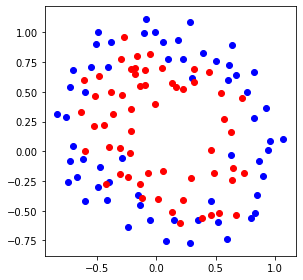

In [42]:
plt.figure()
plt.scatter(pointX0, pointY0, c='b')
plt.scatter(pointX1, pointY1, c='r')
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 2. Plot the training error with varying regularization parameters
## 3. Display the values of the chosen regularization parameters

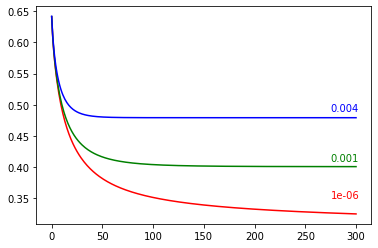

In [46]:
iter_x = list(range(iteration))

plt.plot(iter_x, losses[0], color='red')
plt.plot(iter_x, losses[1], color='green')
plt.plot(iter_x, losses[2], color='blue')

plt.text(275, 0.35, str(reg_const[0]), color='red')
plt.text(275, 0.41, str(reg_const[1]), color='green')
plt.text(275, 0.49, str(reg_const[2]), color='blue')

plt.show()

## 4. Plot the training accuracy with varying regularization parameters
## 5. Display the final training accuracy with varying regularization parameters

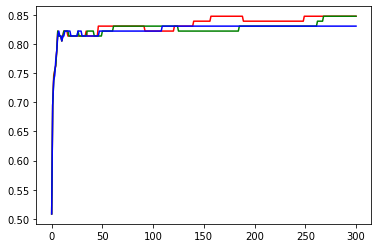

In [48]:
plt.plot(iter_x, accuracies[0], color='red')
plt.plot(iter_x, accuracies[1], color='green')
plt.plot(iter_x, accuracies[2], color='blue')
plt.show()